# Animate

This notebook generate an animation  used in 
[our paper](https://doi.org/10.1145/3411764.3445729) on _Proxemics and Social 
Interactions in an Instrumented Virtual Reality Workshop_. 

## Using this Notebook, Code, or Data
This notebook and all of the resources included here are released on a 
[Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).  The data 
is released under [CC-BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).
To cite the paper, the bespoke logging client, the dataset, or this notebook 
please see the [README.md](https://github.com/ayman/hubs-research-2021/blob/main/README.md) 
or the [DOI in the ACM Digital Library](https://doi.org/10.1145/3411764.3445729).

## Requirements

In [1]:
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle
from IPython.display import HTML, Image
from PIL import Image
import glob
import matplotlib.lines as mlines
import numpy as np
import os
import pandas as pd
import time


%matplotlib inline
%matplotlib notebook

In [2]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [3]:
room_data = pd.read_csv('outputs/main_room_resampled_0.167.csv')
room_data = room_data.sort_values('timestamp')

room_data = room_data.assign(id=(room_data.uuid).astype('category').cat.codes)
max_id = room_data.id.max()
room_data['direction_x_coord'] = room_data.position_x+room_data.direction_x
room_data['direction_z_coord'] = room_data.position_z+room_data.direction_z

In [4]:
animation_block = room_data[('2020-04-29 13:41:37.500000+00:00' <= room_data['frame_id'])
                            & (room_data['frame_id'] <= '2020-04-29 18:12:48.250000+00:00')]

frames = [group for name, group in animation_block.groupby('frame_id')]

print(len(frames), len(animation_block), max_id)

1967 21949 22


In [5]:
if not os.path.exists('outputs/animation/'):
    os.makedirs('outputs/animation/')

So this is a bit messy...ideally we should use `animation.FuncAnimation` to animate and save it, but instead we're going to just write each frame by frame as a PNG and then stack a GIF later.

<IPython.core.display.Javascript object>


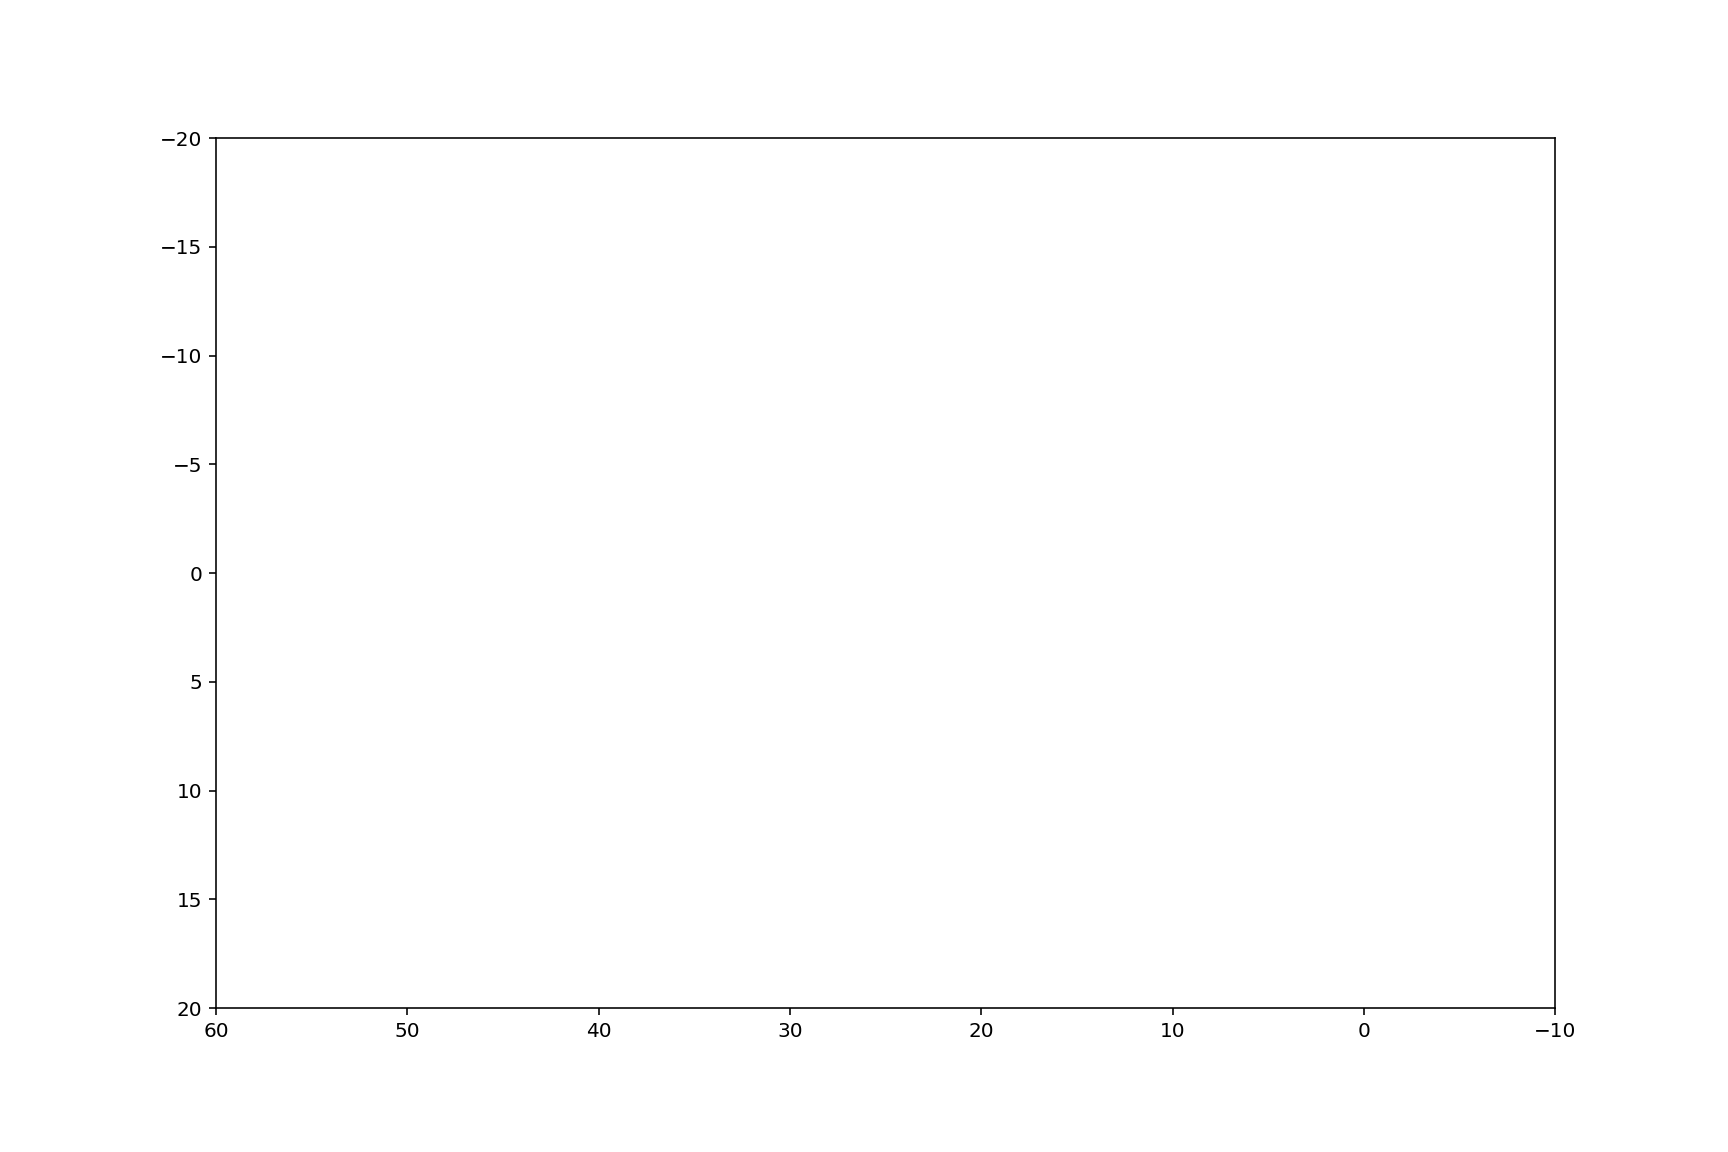

In [6]:
fig, ax = plt.subplots()
plt.xlim((60, -10))
plt.ylim((20, -20))

def init():
    plt.cla()
    ax = plt.gca()
    ax.invert_yaxis()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.xlim((60, -10))
    plt.ylim((20, -20))
    background = plt.imread('assets/Outdoor Meetup Lit with Grid Light.png')    
    # For Lake Office
    # plt.imshow(background, extent=[-10, 10, 10, -15])
    # For Outdoor Meetup
    plt.imshow(background, extent=[60, -10, 20, -20])
    return ax,

def draw_circles(ax, size, xs, ys, alpha, linewidth):
    pos = np.vstack((xs, ys)).T
    for xy in pos:
        c = Circle(xy, size, color='white', alpha=alpha,
                   linewidth=linewidth, clip_on=True)
        ax.add_patch(c)

def animate(i, forpng=False, showCirlces=False):
    # Y axis inverted for both outdoor meetup and lake office
    plt.gca().invert_yaxis()
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.xlim((60, -10))
    plt.ylim((20, -20))
    # Add Background
    # background = plt.imread('assets/Outdoor Meetup Wireframe without Grid.png')
    background = plt.imread('assets/Outdoor Meetup Lit with Grid Light.png')
    # For Lake Office
    # plt.imshow(background, extent=[-10, 10, 10, -15])
    # For Outdoor Meetup
    plt.imshow(background, extent=[60, -10, 20, -20])

    ax = plt.gca()

    this_frame = frames[i].sort_values('frame_id')

    # For Outdoor Meetup
    if forpng:
     scat = ax.scatter(this_frame.position_z, 
                       this_frame.position_x,
                       c=this_frame.id, 
                       cmap='rainbow', 
                       s=12, 
                       zorder=10)
    else:
        ax.set_offsets(this_frame.position_z, 
                       this_frame.position_x)
        
    # If we want circles to show proximity zones
    if showCirlces:
        draw_circles(ax, 1.2, this_frame.position_z,
                     this_frame.position_x, alpha=.1, linewidth=0)
        draw_circles(ax, 3.6, this_frame.position_z,
                     this_frame.position_x, alpha=.1, linewidth=0)
        draw_circles(ax, 7.6, this_frame.position_z,
                     this_frame.position_x, alpha=.05, linewidth=0)

    # For Lake Office
    # ax.scatter(this_frame.position_x, this_frame.position_z, 
    #            c=this_frame.id, cmap='rainbow', zorder=10)

    # For Outdoor Meetup
    ys = np.stack([this_frame.position_x, 
                   this_frame.direction_x_coord, 
                   np.full(this_frame.position_x.shape, 
                           np.nan)])
    xs = np.stack([this_frame.position_z, 
                   this_frame.direction_z_coord, 
                   np.full(this_frame.position_z.shape, 
                           np.nan)])

    d = 1.2  # length of line
    alpha = np.radians(40)  # Field of view (to one side)

    cs = np.cos(alpha)
    ss = np.sin(alpha)

    ncs = np.cos(-alpha)
    nss = np.sin(-alpha)

    rv_x = this_frame.direction_z * cs - this_frame.direction_x * ss
    rv_y = this_frame.direction_z * ss + this_frame.direction_x * cs
    nrv_x = this_frame.direction_z * ncs - this_frame.direction_x * nss
    nrv_y = this_frame.direction_z * nss + this_frame.direction_x * ncs

    nv_left_x = this_frame.position_z + d * rv_x
    nv_left_y = this_frame.position_x + d * rv_y
    nv_right_x = this_frame.position_z + d * nrv_x
    nv_right_y = this_frame.position_x + d * nrv_y

    rys = np.stack([this_frame.position_x, nv_left_y,
                    np.full(this_frame.position_x.shape, np.nan)])
    rxs = np.stack([this_frame.position_z, nv_left_x,
                    np.full(this_frame.position_z.shape, np.nan)])
    nrys = np.stack([this_frame.position_x, nv_right_y,
                     np.full(this_frame.position_x.shape, np.nan)])
    nrxs = np.stack([this_frame.position_z, nv_right_x,
                     np.full(this_frame.position_z.shape, np.nan)])

    # # For Lake Office
    # xs = np.stack([this_frame.position_x, this_frame.direction_x_coord, np.full(this_frame.position_x.shape, np.nan)])
    # ys = np.stack([this_frame.position_z, this_frame.direction_z_coord, np.full(this_frame.position_z.shape, np.nan)])

    # for index, row in this_frame.iterrows():
    # ax.text(row.position_z, row.position_x, row.display_name)

    # Create View Angle Lines
    # ax.plot(xs.T.ravel(), ys.T.ravel(), c='black', linewidth=1)
    if forpng:
        ax.plot(rxs.T.ravel(), rys.T.ravel(), c='black', linewidth=1, alpha=.4)
        ax.plot(nrxs.T.ravel(), nrys.T.ravel(), c='black', linewidth=1, alpha=.4)

        ax.set_title(this_frame['frame_id'].iloc[0][:19], loc='left')
        ax.axis("off")
        return ax
    else:
        ax.set_data(rxs.T.ravel(), rys.T.ravel())
        ax.set_data(nrxs.T.ravel(), nrys.T.ravel())
        return ax,

You can plot any frame like:
```
init()
animate(100, True)
``` 
so we'll just loop and make all the PNGs we need for our flipbook animation.

In [7]:
# Dynamically pad our zeros to the log and filenames.
f_len = len(str(len(frames)))
info_test = "Frame {}/{} @ FPS {}"
info_test = info_test.format("{:>" + str(f_len) + "}", 
                             "{:<" + str(f_len) + "}", 
                             "{:<.5f}")
filename = "outputs/animation/main_room{}.png"
filename = filename.format("{0:0>" + str(f_len) +"}")

# Iterate over all the frames
last_time = time.time() * 1000
for i in range(0, len(frames)):
    init()
    animate(i, True, True)
    plt.savefig(filename.format(i), 
                dpi=150) 
    plt.cla()
    this_time = time.time() * 1000
    t_delta = this_time - last_time
    last_time = this_time
    if (i % 20 == 0):
        print(info_test.format(i, len(frames), (1000/t_delta)))
print("fin...")

Frame    0/1967 @ FPS 2.64083
Frame   20/1967 @ FPS 2.76252
Frame   40/1967 @ FPS 2.96476
Frame   60/1967 @ FPS 2.98747
Frame   80/1967 @ FPS 2.77985
Frame  100/1967 @ FPS 2.72491
Frame  120/1967 @ FPS 2.73203
Frame  140/1967 @ FPS 2.86422
Frame  160/1967 @ FPS 2.79507
Frame  180/1967 @ FPS 2.80575
Frame  200/1967 @ FPS 2.89850
Frame  220/1967 @ FPS 2.59197
Frame  240/1967 @ FPS 2.57101
Frame  260/1967 @ FPS 2.57620
Frame  280/1967 @ FPS 2.72444
Frame  300/1967 @ FPS 2.72521
Frame  320/1967 @ FPS 2.72936
Frame  340/1967 @ FPS 2.53735
Frame  360/1967 @ FPS 2.49898
Frame  380/1967 @ FPS 2.47088
Frame  400/1967 @ FPS 2.70451
Frame  420/1967 @ FPS 2.65688
Frame  440/1967 @ FPS 2.63351
Frame  460/1967 @ FPS 2.62749
Frame  480/1967 @ FPS 2.76586
Frame  500/1967 @ FPS 2.83047
Frame  520/1967 @ FPS 2.88571
Frame  540/1967 @ FPS 2.89558
Frame  560/1967 @ FPS 2.25565
Frame  580/1967 @ FPS 2.84440
Frame  600/1967 @ FPS 2.84066
Frame  620/1967 @ FPS 2.73725
Frame  640/1967 @ FPS 2.62284
Frame  660

Let's write the frames to a GIF

## Render frames as PNGs
This will make a rather large GIF file out of all the saved PNGs.

In [65]:
def save_gif(filename, imgs, resize=None):
    frames = []
    for i in imgs:
        new_frame = Image.open(i)
        if resize is not None:
            # new_frame = new_frame.resize(resize)
            new_frame.thumbnail(resize, Image.LANCZOS)
        frames.append(new_frame)

    frames[0].save(filename,
                   format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=60, 
                   loop=True,
                   optimize=False)

In [63]:
imgs = glob.glob("outputs/animation/*.png")
imgs.sort()
save_gif("outputs/main_animation.gif", imgs)

Let's save a smaller GIF with less frames.

In [68]:
import math 
start = math.floor(len(frames)/2)
end = start + 50
imgs_small = imgs[start:end]
save_gif("outputs/main_animation_small.gif", imgs_small)

## Render frames as MP4
You'll need OpenCV for this.

In [19]:
import cv2

imgs = glob.glob("outputs/animation/*.png")
imgs.sort()

img0 = cv2.imread(imgs[0])
height , width , layers =  img0.shape

video = cv2.VideoWriter('outputs/video.mp4', 
                        cv2.VideoWriter_fourcc(*'MP4V'),
                        30,
                        (width, height))
for i in imgs:
    image = cv2.imread(i)
    video.write(image)

cv2.destroyAllWindows()
video.release()

## Render frames as animations
### ⚠️ Caution ⚠️ 
What we _want_ to do is write an animation as follows. This section isn't working... It is included here for a rough reminder on how to display the animation inline in the notebook.  However the `animate(i)` function needs to be updated to correctly render the frames.

In [ ]:
# this is not working (yet!)
anim = animation.FuncAnimation(fig, 
                               animate, 
                               init_func=init,
                               frames=len(frames), 
                               interval=50, 
                               blit=True)
plt.show()